# Assignment 2 - Research Track 2

Second assignment for Research Track 2 course.
By **Miguel Angel Sempere Vicente (S5646720)**.


## Robot’s and targets’ positions in the environment

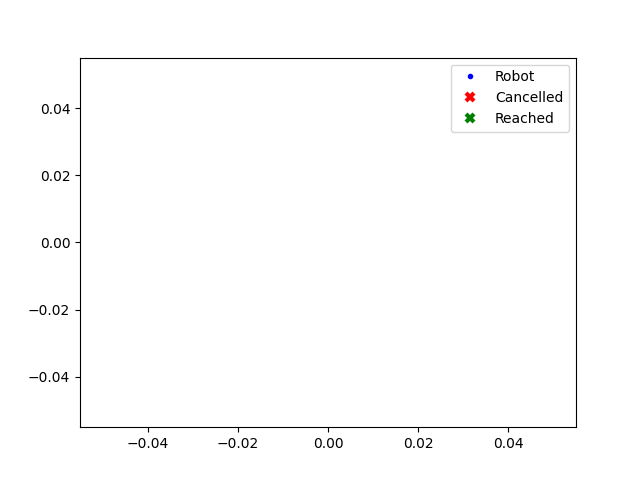

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import rospy
import tf
import jupyros as jr
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalID
import assignment_2_2022.msg
import numpy as np
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation

goals_cancelled = 0
goals_reached = 0

class VisualiserMap:
    def __init__(self):
        # Initialize the visualization map
        self.fig_map, self.ax = plt.subplots()
        self.robot, = plt.plot([], [], 'bo', label="Robot", markersize=3)
        self.cancelled, = plt.plot([], [], 'rx', label="Cancelled", markeredgewidth=3)
        self.reached, = plt.plot([], [], 'gx', label="Reached", markeredgewidth=3)
        self.x_data, self.y_data = [] , []
        self.x_reached, self.y_reached = [] , []
        self.x_cancelled, self.y_cancelled = [] , []
        self.current_goal = []
        plt.legend()
        
    def plot_init(self):
        # Initialize the plot with axes limits and labels
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title('Environment plot')
        return self.robot, self.cancelled, self.reached
    
    def odom_callback(self, msg):
        # Callback function for the Odometry topic
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def goal_callback(self, msg):
        # Callback function for the goal message
        self.current_goal = [msg.goal.target_pose.pose.position.x, msg.goal.target_pose.pose.position.y]
        
    def result_callback(self, msg):
        # Callback function for the planning result
        global goals_cancelled, goals_reached
        goal_x = self.current_goal[0]
        goal_y = self.current_goal[1]
        if msg.status.status == 3:  # Reached goal
            self.x_reached.append(goal_x)
            self.y_reached.append(goal_y)
            goals_reached = goals_reached + 1
        elif msg.status.status == 2:  # Cancelled goal
            self.x_cancelled.append(goal_x)
            self.y_cancelled.append(goal_y)
            goals_cancelled = goals_cancelled + 1
            
    def update_plot(self, frame):
        # Update the plot with new data points
        self.robot.set_data(self.x_data, self.y_data)
        self.cancelled.set_data(self.x_cancelled, self.y_cancelled)
        self.reached.set_data(self.x_reached, self.y_reached)
        return self.robot, self.cancelled, self.reached

vis_map = VisualiserMap()    

rospy.init_node('jupyter_a')
rospy.Subscriber('/odom', Odometry, vis_map.odom_callback)
rospy.Subscriber('/reaching_goal/result', assignment_2_2022.msg.PlanningActionResult, vis_map.result_callback)
rospy.Subscriber('/reaching_goal/goal', assignment_2_2022.msg.PlanningActionGoal, vis_map.goal_callback)

ani_map = FuncAnimation(vis_map.fig_map, vis_map.update_plot, init_func=vis_map.plot_init, cache_frame_data=False)
plt.show(block=False)

## Buttons for handling the motion of the robot 

In [2]:
goal_points = []

# Function to handle button click events
def on_send_button_clicked(b):
    try:
        x = float(x_textbox.value)
        y = float(y_textbox.value)
        goal_points.append((x, y))
        goal_msg = assignment_2_2022.msg.PlanningActionGoal()
        goal_msg.goal.target_pose.pose.position.x = x
        goal_msg.goal.target_pose.pose.position.y = y
        goal_pub.publish(goal_msg)
        print("Goal point sent:", (x, y))
    except ValueError:
        print("Invalid input")

def on_delete_button_clicked(b):
    if len(goal_points) > 0:
        goal = goal_points.pop()
        cancel_msg = GoalID()
        cancel_pub.publish(cancel_msg)
        print("Deleted goal point:", goal)
    else:
        print("No goal points to delete")

x_textbox = widgets.FloatText(description='X Coord:')
y_textbox = widgets.FloatText(description='Y Coord:')

send_button = widgets.Button(description='Send new goal')
delete_button = widgets.Button(description='Delete goal')

send_button.on_click(on_send_button_clicked)
delete_button.on_click(on_delete_button_clicked)

goal_pub = rospy.Publisher('/reaching_goal/goal', assignment_2_2022.msg.PlanningActionGoal, queue_size=10)
cancel_pub = rospy.Publisher('/reaching_goal/cancel', GoalID, queue_size=10)

widgets.HBox([widgets.VBox([send_button, delete_button]),widgets.VBox([x_textbox, y_textbox])])


Goal point sent: (0.0, 0.0)
Goal point sent: (3.0, 3.0)
Deleted goal point: (3.0, 3.0)


## Distance to the closest obstacle

In [3]:
def laser_callback(msg):
    # Callback function for the LaserScan topic
    global distancew
    # Update the value with the minimum of the laser measurements
    distancew.value = min(msg.ranges)

rospy.Subscriber('/scan', LaserScan, laser_callback)

distancew = widgets.FloatText(value = 0, description='Closest obstacle at:', continuous_update=True)

display(distancew)


FloatText(value=0.0, continuous_update=True, description='Closest obstacle at:')

## Number of reached / not-reached targets

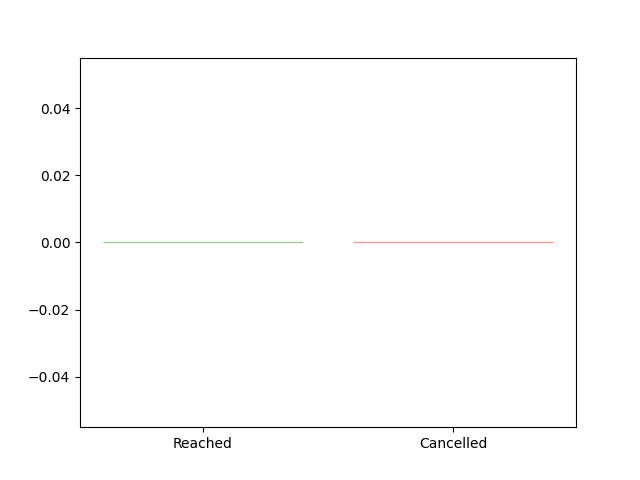

In [4]:
global goals_cancelled, goals_reached

class VisualiserGoals:
    def __init__(self):
        # Initialize the goals graph visualization
        global goals_cancelled, goals_reached
        self.fig_barchart, self.ax = plt.subplots()
        self.labels = ['Reached', 'Cancelled']
        self.values = [goals_reached, goals_cancelled]
        self.bars = self.ax.bar(self.labels, self.values, align = 'center', alpha = 0.4)
        self.bars[0].set_color('green')
        self.bars[1].set_color('red')
        
    def plot_init(self):
        # Initialize the bar chart plot with labels and title
        self.ax.set_ylabel('Number')
        self.ax.set_title('Goals Summary')
        return self.bars

    def update_graph(self, frame):
        # Update the graph with the latest values of goals_reached and goals_cancelled
        global goals_cancelled, goals_reached
        self.values[0] = goals_reached
        self.values[1] = goals_cancelled
        plt.yticks(np.arange(0, max([goals_reached, goals_cancelled])+2, 1))
        self.bars[0].set_height(goals_reached)
        self.bars[1].set_height(goals_cancelled)
        return self.bars 

vis_goals = VisualiserGoals()

ani_goals = FuncAnimation(vis_goals.fig_barchart, vis_goals.update_graph, init_func=vis_goals.plot_init, cache_frame_data=False)

plt.show()